In [1]:
import fastai
from fastai.fautils import *

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt

In [3]:
full_data_path = os.path.expanduser('~/data/state-farm/')
samp_data_path = os.path.expanduser('~/data/sample-state-farm/')
data_path = full_data_path
batch_size = 32

In this notebook, we experiment with splitting VGG into to convolutional and fully connected layers to accelerate the fine-tuning process.  When fine-tuning, we generally don't alter the convolutional layers.  They've been learned from very large datasets and tend to be tuned to the distribution of image content (to some degree more or less depending on the distribution of data and labels -- ala the Imagenet tendency towards dog faces).

The reason for this approach is that most of the computational work is in the convolutional layers.  Since they tend not to change in most experiments (the computational cost of training them anew to convergence is too high), we can precompute them.  Then we can construct a second network that takes the output of the convolution-only network as input and can iterate much more rapidly on that.

We're going to:

- construct a conventional VGG model
- split it at the division between the convolutional layers and the FC layers
- we'll take our entire dataset and run it through the convolutional layers, and store the result
- we'll then construct a secondary model that takes the convolutional output for input, and outputs the desired prediction
- we'll then train that network on the stored convolutional output

This way we can reduce a 10+ minute training per epoch to 22 seconds.

# create batches

In [4]:
gen_t = image.ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.15,
    shear_range=0.15,
    rotation_range=15,
    channel_shift_range=30
)

t_batches = get_batches(data_path + 'train', batch_size=batch_size, shuffle=False)
v_batches = get_batches(data_path + 'valid', batch_size=2*batch_size, shuffle=False)
a_batches = get_batches(data_path + 'train', gen_t, batch_size=batch_size)

(
    val_classes, trn_classes, 
    val_labels, trn_labels, 
    val_filenames, filenames,
    test_filename
) = get_classes(data_path)

Found 20315 images belonging to 10 classes.
Found 2109 images belonging to 10 classes.
Found 20315 images belonging to 10 classes.
Found 20315 images belonging to 10 classes.
Found 2109 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


# construct initial VGG network, then split

In [5]:
from fastai import vgg162
from keras.applications import VGG16

# vgg = vgg_ft(10)
# model = vgg.model

model = VGG16(pooling='max')
# model.summary()

In [6]:
# def finetune(model, n):
#     model.layers.pop()
#     for layer in model.layers: 
#         layer.trainable=False
#     model.layers.add(keras.layers.Dense(num, activation='softmax'))
#     self.compile()
    
#     return model

In [7]:
# model = finetune(model, 10)

lr = 1e-3
epochs = 25.
decay_rate = lr / epochs

model.compile(
    optimizer=Adam(lr=1e-3, decay=decay_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
# h = model.fit_generator(
#     t_batches, 
#     t_batches.nb_sample, 
#     nb_epoch=25, 
#     validation_data=v_batches, 
#     nb_val_samples=v_batches.nb_sample
# )

In [9]:
layers = model.layers

last_conv_idx = [
    index 
    for index, layer in enumerate(layers)
    if type(layer) is Conv2D
][-1]

print(last_conv_idx)
layers[last_conv_idx]

17


In [10]:
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)

In [ ]:
fc_layers = layers[last_conv_idx+1:]
fc_model = Sequential(fc_layers)

# precompute, store reload

In [ ]:
t_features = conv_model.predict_generator(t_batches, t_batches.samples)
v_features = conv_model.predict_generator(v_batches, v_batches.samples)

save_array(data_path + 'train_convlayer_features.bc', t_features)
save_array(data_path + 'valid_convlayer_features.bc', v_features)

In [ ]:
t_features = load_array(data_path + 'train_convlayer_features.bc')
v_features = load_array(data_path + 'valid_convlayer_features.bc')

t_features.shape

# create second network and train

**NOTE:** I had hoped to just use the 2nd half of the split network above directly, but that didn't work.  I needed to recreate it with the same configuration as I did here.  Or I could have chose another configuration entirely.

Regardless, I think you need to manually recreate the new network, opposed to borrowing the previously-split one.  That's something to be validated.

The most important part is the first level.  I'm not sure why the tutorial said to include the max pooling layer here, opposed to leave it in the convolutional precomputation.  But the `input_shape` is important to match to the dimensions shown in `t_features.shape` above.  Except the first dimension, that's the numeber of examples.  We exclude that.

In [24]:
lr = 1e-5
epochs = 25.
decay_rate = lr / epochs

model = Sequential([
    MaxPooling2D((2, 2), strides=(2, 2), input_shape=(512, 14, 14)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(.5),
    Dense(4096, activation='relu'),
    Dropout(.5),
    Dense(10, activation='softmax'),
])

model.compile(
    optimizer=Adam(lr=lr, decay=decay_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
h = model.fit(
    t_features, 
    trn_labels, 
    nb_epoch=25,
    batch_size=batch_size,
    validation_data=(v_features, val_labels)
)

Train on 20424 samples, validate on 2000 samples
Epoch 1/25
20424/20424 [==============================] - 22s - loss: 7.5257 - acc: 0.4363 - val_loss: 1.1177 - val_acc: 0.9025
Epoch 2/25
20424/20424 [==============================] - 22s - loss: 1.8291 - acc: 0.8290 - val_loss: 0.2732 - val_acc: 0.9705
Epoch 3/25
20424/20424 [==============================] - 22s - loss: 0.8057 - acc: 0.9198 - val_loss: 0.1633 - val_acc: 0.9815
Epoch 4/25
20424/20424 [==============================] - 22s - loss: 0.4859 - acc: 0.9471 - val_loss: 0.1060 - val_acc: 0.9905
Epoch 5/25
20424/20424 [==============================] - 22s - loss: 0.3180 - acc: 0.9634 - val_loss: 0.0671 - val_acc: 0.9910
Epoch 6/25
20424/20424 [==============================] - 22s - loss: 0.2378 - acc: 0.9720 - val_loss: 0.0513 - val_acc: 0.9935
Epoch 7/25
20424/20424 [==============================] - 22s - loss: 0.1759 - acc: 0.9778 - val_loss: 0.0481 - val_acc: 0.9960
Epoch 8/25
20424/20424 [==============================]

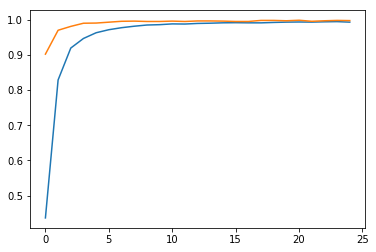

In [28]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])